### Add all imports


In [101]:
# from utils import *
import re
from pyarabic.araby import strip_diacritics
import numpy as np


In [102]:
import unicodedata
import nltk
import torch
from torch import lstm_cell, nn
import time
import random
import pickle as pkl
import tensorflow as tf
import pickle

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional, TimeDistributed , Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split


In [103]:

########################################################################################
# Read the letters from the pickle files which we will use
def get_letters():
    file_path = 'constants/arabic_letters.pickle'
    with open(file_path, 'rb') as file:
        letters = pickle.load(file)
    letters.add("<s>")
    letters.add("</s>")
    letters.add("<PAD>")
    return letters
########################################################################################
# Read the diacritics from the pickle files which we will use
def get_diacritics():
    file_path = 'constants/diacritics.pickle'
    with open(file_path, 'rb') as file:
        diacritics = pickle.load(file)
    # diacritics.add("<s>")
    # diacritics.add("</s>")
    # diacritics.add("<PAD>")
    return diacritics
########################################################################################
# Read the diacritics from the pickle files which we will use
def get_diacritics2id():

    file_path = 'constants/diacritic2id.pickle'
    with open(file_path, 'rb') as file:
        diacritics2id = pickle.load(file)
    # add no tashkeel
    return diacritics2id

########################################################################################
# Read TRAINING dataset given
def read_training_dataset(file_path = "dataset/train.txt"):
    training_sentences = []
    with open(file_path, "r", encoding="utf-8") as file:
        # Read each line in the file
        for line in file:
            # Strip any leading or trailing whitespace from the line
            line = line.strip()
            # Add the line to the list
            training_sentences.append(line)
    if(len(training_sentences)==50000):
        print("Read training set successfully")
        return training_sentences

########################################################################################
# Read DEV dataset given
def read_dev_dataset(file_path = "dataset/val.txt"):
    dev = []
    with open(file_path, "r", encoding="utf-8") as file:
        # Read each line in the file
        for line in file:
            line = line.strip()
            dev.append(line)
    #print(len(dev))
    if(len(dev)==2500):
        print("Read validation set successfully")
        return dev

########################################################################################

def separate_word_to_letters_diacritics(arabic_text, arabic_letters=get_letters()):
    # Normalize the text to handle different Unicode representations
    normalized_text = unicodedata.normalize('NFKD', arabic_text)
    letters = []
    diacritics = []
    # arabic_text = arabic_text[::-1]
    # for ind in range(len(arabic_text)):
    #     print(arabic_text[ind])
    ind=0

    while ind < len(arabic_text):
        temp=[]
        if not unicodedata.combining(arabic_text[ind]):
        # if arabic_text[ind] in arabic_letters:
            letters.append(arabic_text[ind])
            # print("added to letters",arabic_text[ind])

            if(ind+1 < len(arabic_text) and not unicodedata.combining(arabic_text[ind+1])):
                diacritics.append(temp)
                # print("added to diacritics from 1st",temp)
            ind+=1

        else:
            while ind < len(arabic_text) and unicodedata.combining(arabic_text[ind]):
                # diacritics.pop(0)
                temp.append(arabic_text[ind])
                ind+=1
            temp=unicodedata.normalize('NFC', ''.join(temp))
            # temp=[temp[::-1]]
            diacritics.append(temp)
            # print("added to diacritics",temp)
    # letters.reverse()
    # diacritics.reverse()
    return letters, diacritics

########################################################################################
def tokenize_to_vocab(data, vocab):
    tokenized_sentences_word, tokenized_sentences_letters, tokenized_sentences_diacritics = [], [],[]

    for d in (data):
            tokens = nltk.word_tokenize(d, language="arabic", preserve_line=True)
            # Add the start sentence <s> and end sentence </s> tokens at the beginning and end of each tokenized sentence
            tokens.reverse()
            tokens.insert(0,"<s>")
            tokens.append("</s>")

            vocab.update(tokens)

            word_letters=[]
            word_diacritics=[]
            for token in (tokens):
                if token != "<s>" and token != "</s>":
                    # letters = separate_arabic_to_letters(token)
                    letter, diacritic = separate_word_to_letters_diacritics(token)
                    word_diacritics.append(diacritic)
                    word_letters.append(letter)
                else:
                    word_letters.append(token)
                    word_diacritics.append(token)

            tokenized_sentences_letters.append(word_letters)
            tokenized_sentences_diacritics.append(word_diacritics)
            tokenized_sentences_word.append(tokens)

    return vocab, tokenized_sentences_word,tokenized_sentences_letters,tokenized_sentences_diacritics

def extract_sentences(training_dataset):
    # This pattern keeps Arabic letters, diacritics, and whitespaces and endlines
    pattern = re.compile(r'[^\u0600-\u06FF\u0750-\u077F\u08A0-\u08FF\s,.؟،;:!?\-\'"]')

    # Replace unmatched characters with an empty string
    cleaned_corpus = [re.sub(pattern, "", t) for t in training_dataset]
    cleaned_corpus = [re.sub("\s\s+", " ", c) for c in cleaned_corpus]

    print(len(cleaned_corpus))

    data,labels = [],[]

    first = True
    for c in cleaned_corpus:
        sentences = re.split(r"[,.؟،;:!?']+", c)  # split on all punctuation
        labels += sentences

        without_dialects = [
            strip_diacritics(s) for s in sentences
        ]  # get the letters without dialects
        data += without_dialects


    # remove any spaces from line
    data = [d.strip() for d in data]
    labels = [l.strip() for l in labels]

    # remove empty lines
    data = [i for i in data if i]
    labels = [i for i in labels if i]
    return data,labels,cleaned_corpus


########################################################################################

# l,d=separate_word_to_letters_diacritics('زُنَّارٍ')
# # print(len(l),len(d))
# # for i in range(len(d)):
# #     # print(l[i],d[i],)
# #     if(len(d[i])>0):
# #         print(diacritics2id[d[i][0]])

# print(id2diacritics[2])
# print(id2diacritics[0])
# print(id2diacritics[5])

### Read Data

In [104]:
training_dataset = read_training_dataset()
dev_dataset = read_dev_dataset()
# test_dataset = read_test_dataset()
training_dataset=training_dataset[:20]
dev_dataset=dev_dataset[:2]

Read training set successfully
Read validation set successfully


In [105]:
# l,d=separate_word_to_letters_diacritics('زُنَّارٍ')
# print(len(l),len(d))
# for i in range(len(d)):
#     print(l[i],d[i],len(d[i]))
# for k,v in diacritics2id.items():
#     print(k)
# print(diacritics2id)
# print(separate_word_to_letters_diacritics('قَوْلُهُ'))

4 4
ز ُ 1
ن َّ 2
ا [] 0
ر ٍ 1


### Pre-process and clean data

In [106]:
# 1- Clean the data
data, labels, cleaned_corpus = extract_sentences(training_dataset)
val_data, val_labels, val_cleaned_corpus = extract_sentences(dev_dataset)

# write the clean corpora to file
# with open("./output_data/cleaned_corpus.txt", "w", encoding="utf-8") as f:
#     for l in cleaned_corpus:
#         f.write(l + "\n")

# with open("./output_data/training_data.txt", "w", encoding="utf-8") as f:
#     for d in data:
#         f.write(str(d) + "\n")

# with open("./output_data/labeled/training_labels.txt", "w", encoding="utf-8") as f:
#     for l in labels:
#         f.write(str(l) + "\n")


20
2


In [107]:
# 2- Tokenize to vocab and words
vocab = set()
tokenized_data = []
vocab, tokenized_word_sentence, tokenized_letter_sentence, tokenized_diacritics_sentence = tokenize_to_vocab(labels, vocab)
stemmedVocab = []

# Save the vocab to file each word in a line
# with open("./output_data/vocab.txt", "w", encoding="utf-8") as f:
#     for v in vocab:
#         f.write(str(v) + "\n")

# # save the tokenized data sentence, as a form of list with <s> in index 0 and </s> in the last index
#         # in between are words
# with open("./output_data/tokenized_data_sentences.txt", "w", encoding="utf-8") as f:
#     for ts in tokenized_word_sentence:
#         f.write(str(ts) + "\n")

# # save the tokenized data sentence, as a form of list with <s> in index 0 and </s> in the last index
#         # in between are lists of letters
# with open("./output_data/tokenized_data_letters.txt", "w", encoding="utf-8") as f:
#     for tl in tokenized_letter_sentence:
#         f.write(str(tl) + "\n")

# # save the tokenized data sentence, as a form of list with <s> in index 0 and </s> in the last index
#         # in between are lists of diacritics
# with open("./output_data/tokenized_data_diacritics.txt", "w", encoding="utf-8") as f:
#     for td in tokenized_diacritics_sentence:
#         f.write(str(td) + "\n")


### Features & embeddings

In [114]:
#1- Read data embeddings we have for letters and diacritics
letters, diacritics, diacritics2id = get_letters() , get_diacritics(), get_diacritics2id()
#2- Have mapping ready
#### Letters ---- IDs
letters2id = {item: index for index, item in enumerate(letters)}
id2letters = {index: item for index, item in enumerate(letters)}


#### Diacritics ---- IDs
# id2diacritics = {index: item for index, item in enumerate(diacritics)}
# print(diacritics2id['ُ'])
# print(id2diacritics[2])


# add <PAD> to the mapping
diacritics2id['<PAD>'] = len(diacritics2id)-1
diacritics2id['<s>'] = len(diacritics2id)
diacritics2id['</s>'] = len(diacritics2id)
diacritics2id[''] = len(diacritics2id)-1
id2diacritics = {value: key for key, value in diacritics2id.items()}

for diacritic, id in diacritics2id.items():
        if diacritic not in diacritics:
          diacritics.add(diacritic)

for letter, id in letters2id.items():
        if letter not in letters:
          letters.add(letter)
print(diacritics2id)


{'َ': 0, 'ً': 1, 'ُ': 2, 'ٌ': 3, 'ِ': 4, 'ٍ': 5, 'ْ': 6, 'ّ': 7, 'َّ': 8, 'ًّ': 9, 'ُّ': 10, 'ٌّ': 11, 'ِّ': 12, 'ٍّ': 13, '': 15, '<PAD>': 14}


In [116]:
# letters, diacritics, diacritics2id
def map_data(data_raw):
    ''' Splists data lines into an array of charachers as integers and an array of discritics as one-hot-encodings '''

    # initialize data and diacritics lists
    X = list()
    Y = list()

    # loop on data lines
    for line in data_raw:
        
        lit,dicc=separate_word_to_letters_diacritics(line)
        # for each sub list in dicc , if the len of the list is greater than 1 then take the last element only
        # if the size is zero assert that the size is zero
        # for i in range(len(dicc)):
        #     if len(dicc[i])>=1:
        #         dicc[i]=dicc[i][-1]
        #     elif len(dicc[i])==0:
        #         dicc[i]='<s>'

        # initialize line data and diacritics lists and add start of sentence character
        x = [letters2id['<s>']]
        y = [diacritics2id['<s>']]
        x=[]
        y=[]
        for i in range(min(len(lit),len(dicc))):
            if len(dicc[i])>=1:
                dicc[i]=dicc[i][0]
            elif len(dicc[i])==0:
                dicc[i]=''
            if dicc[i] not in diacritics2id:
                dicc[i]=''
                
            if lit[i] not in letters2id:
                lit[i]='<PAD>'
                dicc[i]='<PAD>'

            x.append(letters2id[lit[i]])
            y.append(diacritics2id[dicc[i]])

        # assert characters list length equals diacritics list length
        # assert(len(x) == len(y))

        # append end of sentence character
        x.append(letters2id['</s>'])
        y.append(diacritics2id['</s>'])

        # convert diacritics integers to one_hot_encodings
        # print(y)
        y = to_categorical(y, len(diacritics2id))

        # append line's data and diacritics lists to total data and diacritics lists
        X.append(x)
        Y.append(y)
    # convert lists to numpy arrays
    # X = np.asarray(X)
    # Y = np.asarray(Y)

    return X, Y
class DataGenerator(Sequence):
    ''' Costumized data generator to input line batches into the model '''
    def __init__(self, lines, batch_size,letters2id, diacritics2id):
        self.lines = lines
        self.batch_size = batch_size
        self.letters2id = letters2id
        self.diacritics2id = diacritics2id

    def __len__(self):
        return int(np.ceil(len(self.lines) / float(self.batch_size)))

    def __getitem__(self, idx):
        lines = self.lines[idx * self.batch_size:(idx + 1) * self.batch_size] # load number of sentences equal to batch size
        X_batch, Y_batch = map_data(lines) # map data to integers and one-hot-encodings
        X_max_seq_len = np.max([len(x) for x in X_batch])
        Y_max_seq_len = np.max([len(y) for y in Y_batch])
        assert(X_max_seq_len == Y_max_seq_len)
        X = list()
        for x in X_batch:
            x = list(x)
            x.extend([self.letters2id['<PAD>']] * (X_max_seq_len - len(x)))
            X.append(np.asarray(x))

        Y_tmp = list()
        for y in Y_batch:
            y_new = list(y)
            y_new.extend(to_categorical([self.diacritics2id['<PAD>']] * (Y_max_seq_len - len(y)), len(diacritics2id)))
            Y_tmp.append(np.asarray(y_new))
        Y_batch = Y_tmp
        X_batch = np.array(X)
        Y_batch = np.asarray(Y_batch)

        return (X_batch, Y_batch)

########################################################################################
def create_model(CHARACTERS_MAPPING, CLASSES_MAPPING ):
    ''' Creates diacritization model '''
    SelectedLSTM = LSTM # Bidirectional Long Short-Term Memory 

    inputs = Input(shape=(None,))

    embeddings = Embedding(input_dim=len(CHARACTERS_MAPPING),
                           output_dim=25,
                           embeddings_initializer=glorot_normal(seed=961))(inputs)

    blstm1 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(embeddings)
    dropout1 = Dropout(0.5)(blstm1)
    blstm2 = Bidirectional(SelectedLSTM(units=256,
                                     return_sequences=True,
                                     kernel_initializer=glorot_normal(seed=961)))(dropout1)
    dropout2 = Dropout(0.5)(blstm2)

    dense1 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dropout2)
    dense2 = TimeDistributed(Dense(units=512,
                                   activation='relu',
                                   kernel_initializer=glorot_normal(seed=961)))(dense1)

    output = TimeDistributed(Dense(units=len(CLASSES_MAPPING),
                                   activation='softmax',
                                   kernel_initializer=glorot_normal(seed=961)))(dense2)

    model = Model(inputs, output)

    # compile model
    # model.compile(loss='categorical_crossentropy', optimizer=Adam())
    # use this model to calc the accuracy
    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    return model
########################################################################################

def fit_model(model, epochs, batch_size, train_split,val_split,letters2id, diacritics2id):
    ''' Fits model '''


    # create training and validation generators
    training_generator = DataGenerator(train_split, batch_size,letters2id, diacritics2id)
    val_generator = DataGenerator(val_split, batch_size,letters2id, diacritics2id)

    # fit model
    history = model.fit(x=training_generator,
              validation_data=val_generator,
              epochs=epochs
              )

    # return history
    return history
########################################################################################
def remove_diacritics(data_raw):
  ''' Returns undiacritized text'''
  return data_raw.translate(str.maketrans('', '', ''.join(diacritics)))
def predict(line, model):
    ''' predict test line '''
    X, _ = map_data([line])

    predictions = model.predict(X).squeeze()
    # get most probable diacritizations for each character
    predictions = predictions[1:]

    # initialize empty output line
    output = ''
    # loop on input characters and predicted diacritizations
    for char, prediction in zip(remove_diacritics(line), predictions):
        # print(np.argmax(prediction),len(prediction),len(id2diacritics))

        # append character
        output += char
        # if character is not an arabic letter continue
        if char not in letters:
            continue

        if '<' in id2diacritics[np.argmax(prediction)]:
            continue

        # if character in arabic letters append predicted diacritization
        output += id2diacritics[np.argmax(prediction)]

    return output
# print(predict('ذهب الولد',model))
# print(id2diacritics)
# print(map_data(['قَوْلُهُ']))


In [110]:

#1- We then pass the embeddings to an RNN Model
# This model consists of an embedding layer, an RNN layer, and a fully connected layer. 
# The embedding layer transforms the input words (represented as integers) into dense vectors of fixed size. 
# The RNN layer processes these word embeddings sequentially, 
# maintaining an internal state that encodes information about the sequence so far. T
# he fully connected layer transforms the output of the RNN layer to the desired output size.
# with open( './constants/RNN_BIG_CHARACTERS_MAPPING.pickle', 'rb') as file:
#     CHARACTERS_MAPPING = pkl.load(file)
model = create_model(letters2id, diacritics2id)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 25)          975       
                                                                 
 bidirectional_2 (Bidirecti  (None, None, 512)         577536    
 onal)                                                           
                                                                 
 dropout_2 (Dropout)         (None, None, 512)         0         
                                                                 
 bidirectional_3 (Bidirecti  (None, None, 512)         1574912   
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, None, 512)         0   

### FITING 


In [119]:
start_time = time.time()
hist_1 = fit_model(model, 1, 256, labels, val_labels,letters2id, diacritics2id)
end_time = time.time()
print('--- %s seconds ---' % round(end_time - start_time, 2))

InvalidArgumentError: Graph execution error:

Detected at node gradient_tape/categorical_crossentropy/mul/BroadcastGradientArgs defined at (most recent call last):
  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\ipykernel_launcher.py", line 17, in <module>

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\traitlets\config\application.py", line 992, in launch_instance

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelapp.py", line 711, in start

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\tornado\platform\asyncio.py", line 215, in start

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 596, in run_forever

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1890, in _run_once

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 499, in process_one

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\ipykernel\kernelbase.py", line 729, in execute_request

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\ipykernel\ipkernel.py", line 411, in do_execute

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\ipykernel\zmqshell.py", line 531, in run_cell

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2940, in run_cell

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 2995, in _run_cell

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3194, in run_cell_async

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3373, in run_ast_nodes

  File "C:\Users\ahmed\AppData\Roaming\Python\Python39\site-packages\IPython\core\interactiveshell.py", line 3433, in run_code

  File "C:\Users\ahmed\AppData\Local\Temp\ipykernel_23804\4078592250.py", line 2, in <module>

  File "C:\Users\ahmed\AppData\Local\Temp\ipykernel_23804\2627559258.py", line 144, in fit_model

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1807, in fit

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1154, in train_step

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\optimizers\optimizer.py", line 543, in minimize

  File "c:\Users\ahmed\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\optimizers\optimizer.py", line 276, in compute_gradients

Incompatible shapes: [69,225,16] vs. [69,225,15]
	 [[{{node gradient_tape/categorical_crossentropy/mul/BroadcastGradientArgs}}]] [Op:__inference_train_function_28976]

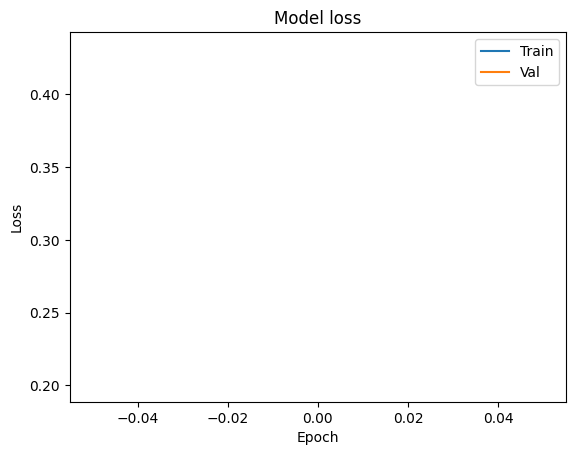

In [ ]:
# plot loss history
plt.plot(hist_1.history['loss'])
plt.plot(hist_1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [ ]:
# test sample
# print(predict('ذهب الولد الي المدرسة', model))
# print(predict("العصفور فوق الشجرة الكبيرة", model))
# print(predict("عبد الرحمن يحب حنان", model))


['ة', 'س', 'ر', 'د', 'م', 'ل', 'ا', ' ', 'ي', 'ل', 'ا', ' ', 'د', 'ل', 'و', 'ل', 'ا', ' ', 'ب', 'ه', 'ذ']
[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


([[26,
   35,
   34,
   0,
   3,
   12,
   1,
   31,
   26,
   13,
   1,
   31,
   26,
   3,
   1,
   22,
   1,
   31,
   26,
   5,
   8,
   6]],
 [array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          1., 0.],
         [0., 0.,

In [ ]:
#2- Get Accuracy
# Training Accuracy
training_accuracy = hist_1.history['accuracy']
# Validation Accuracy
validation_accuracy = hist_1.history['val_accuracy']
final_training_accuracy = training_accuracy[-1]
final_validation_accuracy = validation_accuracy[-1]

print("train accuracy",final_training_accuracy)
print("validation accuracy",final_validation_accuracy)


train accuracy 0.8852115273475647
validation accuracy 0.9260547757148743


In [ ]:
# print(predict("العصفور فوق الشجرة", model))


### Save MODEL

In [ ]:
model.save('my_model1.keras')